# Анализ тональности отзывов о фильмах (на материале рецензий сайта "Кинопоиск")

**Цель:**


Создание модели для анализа тональности киноотзывов на русском языке.

**Инструменты:**

Классические алгоритмы машинного обучения (Multinomial Naive Bayes, C-Support Vector Classification, Logistic Regression, Random Forest, Gradient Boosting, K-Nearest Neighbors, CatBoost), а также трансформер RuBert.

**Датасет:**

Kinopoisk movie reviews dataset (TOP250 & BOTTOM100 rank lists). https://huggingface.co/datasets/blinoff/kinopoisk

Содержит 36 591 рецензий с июля 2004 по ноябрь 2012 года.

In [ ]:
#!pip install pymorphy2
#!pip install xgboost
#!pip install catboost

In [3]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_bar, theme_xkcd, ggtitle, xlab, ylab
%matplotlib inline

import re
import pymorphy2
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report

import pickle

NameError: name 'nltk' is not defined

# Загрузка датасета

Загрузим датасет и посмотрим на него.

In [2]:
df_raw = pd.read_json('data/kinopoisk.jsonl',
                      encoding='utf-8',
                      lines=True)
df_raw.sample(5)

,part,movie_name,review_id,author,date,title,grade3,grade10,content
15718,top250,Начало (2010),2561,te0d0r0,2010-12-23,«Сон или не сон — вот в чем вопрос»,Good,10.0,\nОт своих знакомых я не услышал восхищения от...
5966,top250,Форрест Гамп (1994),782,Great_Skyline,2011-05-01,Невероятная комбинация,Good,10.0,"\nСразу хочу сказать, что такой здоровской ком..."
19382,top250,Адвокат дьявола (1997),15950,GenneArt,2012-03-06,None,Good,0.0,\nДьявол — это искуситель. И он никогда не дае...
19390,top250,Адвокат дьявола (1997),15947,Lady Hell,2010-09-19,"«Определенно, тщеславие — мой любимый грех» (с...",Good,10.0,\nА началось все так… Поздней ночью я читала н...
35753,bottom100,Путевой обходчик (2007),25692,Julia Volf,2011-10-05,беспутный обходчик,Bad,1.0,\n Стоит оценить хотя бы попытку. Именно ...


Слишком много ячеек. Сократим до двух: с самим отзывом и тональностью.

При этом тональность переведем в числовой вид.

In [3]:
df_norm = df_raw.loc[:, ('content',
                         'grade3')]
df_norm.rename(columns={'grade3': 'grade'},
               inplace=True)
df_norm.grade = df_norm.grade.map({'Good': 2,
                                   'Neutral': 1,
                                   'Bad': 0})
df_norm.sample(10)

,content,grade
4400,"\nГай Ричи, гуру лихо закрученного сюжета, мас...",0
1613,\nНазад в будущее — один из самых моих любимых...,2
24465,"\nИногда, вся эта эйфористичная шелуха вроде к...",2
29874,\n«Летит Жозефина в крылатой машине. Все выше ...,2
18877,\nСкорцезе после своего замечательного фильма ...,2
18104,\nСмотрела из любопытства: за что же этим гавр...,2
10648,\nФильм хороший. Но почему-то все восхищаются ...,2
17991,"\nЭтот фильм воспринимается несколько иначе, н...",2
17279,"\nЧарли всегда считал, что его отец уделял ему...",2
9052,"\nЧто меня всегда удивляло в англичанах, так э...",2


Отзывы выглядят не очень, поэтому предобработаем их.

# Предобработка текста

In [5]:
# Приводим к нижнему регистру:
df_norm.insert(2, 'prep', df_norm.content.str.lower())
df_norm.prep.sample(10)

2943     \nпока мориарти с президентской выдержкой заду...
22201    \nчто делать? уйти или остаться? то или это? к...
25555    \nпросто потрясающая комедия с участием несрав...
1584     \nмой любимейший фильм. несмотря на пролетевши...
17259    \nодин из героев фильма — отец чарли и рэймонд...
27267    \nиз двух лент одри тоту, которые я смотрела, ...
7033     \nэто правдивая история о реально существовавш...
21141    \n… причем тут оно и наверное тут есть смысл? ...
17989    \nпосле просмотра фильма меня обуревали двояко...
26728    \nя тоже не согласна!\n\nни разу не пожалела, ...
Name: prep, dtype: object

In [6]:
# Удаляем цифры:
numbers = re.compile(r'\d+')
df_norm.prep = df_norm.prep.str.replace(numbers, '')
df_norm.prep.sample(10)

13983    \nфильм я смотрела уже после прочтения книги, ...
31334    \n      наступил  год, и перед нами предстал д...
26748    \nвпервые посмотрела этот фильм в  лет, воспри...
14601    \nоторвать от экрана меня было довольно трудно...
10067    \nидеальная теория, которая, я думаю, рано или...
27801    \nкнигу м. митчелл «унесенные ветром» я прочит...
22218    \nвозможно ли разглядеть в окружающих нас веща...
24932    \nвсем стоять, не двигаться!\n\nчтиво это буль...
22687    \nкристофер нолан. откуда взялся этот выскочка...
32688    \n      российско-украинский режиссёр, сценари...
Name: prep, dtype: object

In [7]:
# Удаляем латинские буквы
latin = (r'[a-z]+')
df_norm.prep = df_norm.prep.str.replace(latin, ' ')
df_norm.prep[19535]

'\nанимационная картина студии   «балто», начинается как\xa0вполне себе художественный фильм. бабушка с\xa0маленькой внучкой гуляют по\xa0осеннему парку, в\xa0котором находится мемориал посвященный полу волку, полу собаке спасшей в\xa0далеком  году в\xa0аляске детей от\xa0дифтерита. преданное животное смогло проделать невозможно трудный путь и\xa0привезти необходимое лекарство в\xa0маленький городок. гуляя по\xa0парку, бабушка в\xa0подробностях рассказывает трогательную историю своей внучке, а\xa0мы погружаемся в\xa0невероятно красивый рисованный мир, где\xa0все время идет снег, и\xa0где живет самое доброе животное на\xa0свете. очень жаль, что\xa0мне не\xa0довелось увидеть этот мультфильм в\xa0далеком -м году, и\xa0я очень рад, что\xa0восполнил пробел посмотрев его\xa0сейчас. иногда так\xa0хочется погрузиться в\xa0какую-нибудь добрую и\xa0трогательную историю, и\xa0редко какие фильмы, могут похвастаться искренностью и\xa0теплотой истории «балто». к\xa0тому же\xa0у меня сейчас за\xa0окн

In [8]:
# Убираем пунктуацию:
punct = re.compile(r'[^\w\s]')
df_norm.prep = df_norm.prep.str.replace(punct, ' ')
df_norm.prep[19535]

'\nанимационная картина студии    балто   начинается как\xa0вполне себе художественный фильм  бабушка с\xa0маленькой внучкой гуляют по\xa0осеннему парку  в\xa0котором находится мемориал посвященный полу волку  полу собаке спасшей в\xa0далеком  году в\xa0аляске детей от\xa0дифтерита  преданное животное смогло проделать невозможно трудный путь и\xa0привезти необходимое лекарство в\xa0маленький городок  гуляя по\xa0парку  бабушка в\xa0подробностях рассказывает трогательную историю своей внучке  а\xa0мы погружаемся в\xa0невероятно красивый рисованный мир  где\xa0все время идет снег  и\xa0где живет самое доброе животное на\xa0свете  очень жаль  что\xa0мне не\xa0довелось увидеть этот мультфильм в\xa0далеком  м году  и\xa0я очень рад  что\xa0восполнил пробел посмотрев его\xa0сейчас  иногда так\xa0хочется погрузиться в\xa0какую нибудь добрую и\xa0трогательную историю  и\xa0редко какие фильмы  могут похвастаться искренностью и\xa0теплотой истории  балто   к\xa0тому же\xa0у меня сейчас за\xa0окн

In [9]:
# Убираем начало строки:
str_start = re.compile(r'\n?')
df_norm.prep = df_norm.prep.str.replace(str_start, '')
df_norm.prep[19535]

'анимационная картина студии    балто   начинается как\xa0вполне себе художественный фильм  бабушка с\xa0маленькой внучкой гуляют по\xa0осеннему парку  в\xa0котором находится мемориал посвященный полу волку  полу собаке спасшей в\xa0далеком  году в\xa0аляске детей от\xa0дифтерита  преданное животное смогло проделать невозможно трудный путь и\xa0привезти необходимое лекарство в\xa0маленький городок  гуляя по\xa0парку  бабушка в\xa0подробностях рассказывает трогательную историю своей внучке  а\xa0мы погружаемся в\xa0невероятно красивый рисованный мир  где\xa0все время идет снег  и\xa0где живет самое доброе животное на\xa0свете  очень жаль  что\xa0мне не\xa0довелось увидеть этот мультфильм в\xa0далеком  м году  и\xa0я очень рад  что\xa0восполнил пробел посмотрев его\xa0сейчас  иногда так\xa0хочется погрузиться в\xa0какую нибудь добрую и\xa0трогательную историю  и\xa0редко какие фильмы  могут похвастаться искренностью и\xa0теплотой истории  балто   к\xa0тому же\xa0у меня сейчас за\xa0окном

In [10]:
# Убираем другие спецсимволы:
symbols = re.compile(r'[\n\xa0]')
df_norm.prep = df_norm.prep.str.replace(symbols, ' ')
df_norm.prep[19535]

'анимационная картина студии    балто   начинается как вполне себе художественный фильм  бабушка с маленькой внучкой гуляют по осеннему парку  в котором находится мемориал посвященный полу волку  полу собаке спасшей в далеком  году в аляске детей от дифтерита  преданное животное смогло проделать невозможно трудный путь и привезти необходимое лекарство в маленький городок  гуляя по парку  бабушка в подробностях рассказывает трогательную историю своей внучке  а мы погружаемся в невероятно красивый рисованный мир  где все время идет снег  и где живет самое доброе животное на свете  очень жаль  что мне не довелось увидеть этот мультфильм в далеком  м году  и я очень рад  что восполнил пробел посмотрев его сейчас  иногда так хочется погрузиться в какую нибудь добрую и трогательную историю  и редко какие фильмы  могут похвастаться искренностью и теплотой истории  балто   к тому же у меня сейчас за окном тоже идет снег  почти так же как и в мультфильме  что делает просмотр еще более атмосферн

In [11]:
# Убираем лишние пробелы
extra_spaces = re.compile(r'\s{2,}')
df_norm.prep = df_norm.prep.str.replace(extra_spaces, ' ')
df_norm.prep[19535]

'анимационная картина студии балто начинается как вполне себе художественный фильм бабушка с маленькой внучкой гуляют по осеннему парку в котором находится мемориал посвященный полу волку полу собаке спасшей в далеком году в аляске детей от дифтерита преданное животное смогло проделать невозможно трудный путь и привезти необходимое лекарство в маленький городок гуляя по парку бабушка в подробностях рассказывает трогательную историю своей внучке а мы погружаемся в невероятно красивый рисованный мир где все время идет снег и где живет самое доброе животное на свете очень жаль что мне не довелось увидеть этот мультфильм в далеком м году и я очень рад что восполнил пробел посмотрев его сейчас иногда так хочется погрузиться в какую нибудь добрую и трогательную историю и редко какие фильмы могут похвастаться искренностью и теплотой истории балто к тому же у меня сейчас за окном тоже идет снег почти так же как и в мультфильме что делает просмотр еще более атмосферным и сказочным поэтому даже 

In [12]:
df_norm.sample(10)

,content,grade,prep
35291,\n Сложно у нас с мультфильмами. Очень сл...,0,сложно у нас с мультфильмами очень сложно каж...
35678,"\n Создатели немного ошиблись, когда прид...",1,создатели немного ошиблись когда придумывали ...
6387,\n«Путь к свободе и к счастью лежит через высо...,2,путь к свободе и к счастью лежит через высоки...
30757,"\n Я бы не сказал, что первая часть самог...",2,я бы не сказал что первая часть самого лучшег...
27864,"\nЯ, конечно, не любитель аниме, и иногда с пр...",2,я конечно не любитель аниме и иногда с презрен...
30411,\nБесспорно этот мульт Хайао Миядзаки заслужив...,2,бесспорно этот мульт хайао миядзаки заслуживае...
18717,\nФильм Мартина Скорсезе «Остров проклятых» уж...,2,фильм мартина скорсезе остров проклятых уже ок...
21639,\nЧто можно сказать об этом фильме? Много чего...,2,что можно сказать об этом фильме много чего им...
24656,\nПосмотреть этот фильм меня подтолкнули 12 но...,1,посмотреть этот фильм меня подтолкнули номинац...
35344,\n По отношению к этому… слово «фильм» мо...,0,по отношению к этому слово фильм могу писать ...


In [13]:
 # Лемматизация
morph = pymorphy2.MorphAnalyzer()
def lemmatize(tokens):
    return [morph.normal_forms(word)[0] for word in tokens.split()]
df_norm.insert(3, 'lemmas', df_norm.prep.apply(lambda x: lemmatize(x)))
df_norm.sample(10)


,content,grade,prep,lemmas
30954,\n Никогда не относилась к числу поклонни...,0,никогда не относилась к числу поклонников тво...,"[никогда, не, относиться, к, число, поклонник,..."
18758,"\nЯ шел на этот фильм и был уверен, что он мне...",2,я шел на этот фильм и был уверен что он мне по...,"[я, идти, на, этот, фильм, и, быть, уверенный,..."
23858,"\n… крошка-сын к Нолану пришел, и сказала крош...",2,крошка сын к нолану пришел и сказала крошка б...,"[крошка, сын, к, нолана, прийти, и, сказать, к..."
22899,\nИменно эту цитату я бы отнесла к создателям ...,2,именно эту цитату я бы отнесла к создателям фи...,"[именно, этот, цитата, я, бы, отнести, к, созд..."
11568,"\nПосмотрел наконец-то фильм полностью, и да, ...",2,посмотрел наконец то фильм полностью и да эмоц...,"[посмотреть, наконец, то, фильм, полностью, и,..."
28748,"\nНа первый взгляд Шиндлер самовлюблённый, эго...",2,на первый взгляд шиндлер самовлюблённый эгоист...,"[на, один, взгляд, шиндлера, самовлюблённый, э..."
6494,"\nФильм из серии «Посмотреть, чтобы понять, чт...",2,фильм из серии посмотреть чтобы понять что у т...,"[фильм, из, серия, посмотреть, чтобы, понять, ..."
15731,"\nЯ добралась до «Начала», когда наконец-то см...",1,я добралась до начала когда наконец то смолкла...,"[я, добраться, до, начало, когда, наконец, то,..."
33302,"\n «Лопухи» это прежде всего фильм, филь...",1,лопухи это прежде всего фильм фильм который в...,"[лопух, это, прежде, всего, фильм, фильм, кото..."
21882,"\nИнтересно наблюдать за тем, что происходит т...",2,интересно наблюдать за тем что происходит так ...,"[интересно, наблюдать, за, тем, что, происходи..."


In [14]:
# Удаляем стоп-слова
stop = stopwords.words('russian')
stop.extend(['это', 'весь', 'ваш', 'который', 'почему'])
df_norm.lemmas = df_norm.lemmas.apply(lambda x: [item for item in x if item not in stop])
df_norm.sample(10)

,content,grade,prep,lemmas
30557,\nКогда день повторяется вновь и вновь — значи...,2,когда день повторяется вновь и вновь значит с ...,"[день, повторяться, вновь, вновь, значит, твой..."
35839,\n Наконец-то посмотрела этот фильм. Давн...,0,наконец то посмотрела этот фильм давно хотела...,"[посмотреть, фильм, давно, хотеть, посмотреть,..."
1884,\nПотрясающая история про двух смертельно боль...,2,потрясающая история про двух смертельно больны...,"[потрясать, история, смертельно, больной, моло..."
12582,"\nДорогие друзья, как вам? мне? я в смятении!\...",2,дорогие друзья как вам мне я в смятении да это...,"[дорогой, друг, смятение, именно, фильм, заста..."
4239,"\nИногда трейлеры бывают захватывающими, и зри...",2,иногда трейлеры бывают захватывающими и зрител...,"[трейлер, бывать, захватывать, зритель, хотеть..."
17394,"\nФильм интересный и необычный, фильм, показыв...",2,фильм интересный и необычный фильм показывающи...,"[фильм, интересный, необычный, фильм, показыва..."
6613,\n«Секреты Лос-Анджелеса» — одна из лучших экр...,2,секреты лос анджелеса одна из лучших экраниза...,"[секрет, лос, анджелес, хороший, экранизация, ..."
9635,"\nНе могу сказать, что целью у мен является пр...",2,не могу сказать что целью у мен является просм...,"[мочь, сказать, цель, мена, являться, просмотр..."
10013,"\nЗадумывались ли Вы над тем, что «матрица» — ...",1,задумывались ли вы над тем что матрица это не ...,"[задумываться, матрица, столько, фильм, скольк..."
30118,"\nЕсли человек любит и ценит хорошее кино, про...",2,если человек любит и ценит хорошее кино пропус...,"[человек, любить, ценить, хороший, кино, пропу..."


In [15]:
df_norm.to_csv(
        'data/kinopoisk_pp.csv', 
        sep=',',
        index=False,
        encoding='utf-8'
    )

# Предобработка и векторизация датасета

In [4]:
# Удалим ненужные строчки
df_norm = pd.read_csv('data/kinopoisk_pp.csv', 
                      encoding='utf-8')
df_norm.drop(['content', 'prep'], 
             axis=1,
             inplace=True)
df_norm.sample(10)

,grade,lemmas
8495,2,"['хороший', 'фильм', 'реально', 'описывать', '..."
34073,0,"['давно', 'слышать', 'произведение', 'искусств..."
23557,2,"['немногий', 'фильм', 'просмотр', 'впечатление..."
2388,2,"['многие', 'посмотреть', 'фильм', 'некоторые',..."
5854,2,"['роберт', 'земекиса', 'большинство', 'выдающи..."
25401,2,"['наверное', 'десять', 'просмотреть', 'шедевр'..."
15665,2,"['сравнение', 'начать', 'матрица', 'напрашиват..."
24184,2,"['нейтральный', 'отношение', 'фильм', 'бэтмена..."
2101,2,"['сюжет', 'история', 'молодая', 'человек', 'уз..."
33635,0,"['следовать', 'повариться', 'киноиндустрия', '..."


In [9]:
df_norm.shape

(36591, 2)

Посмотрим, как распределены отзывы в датасете

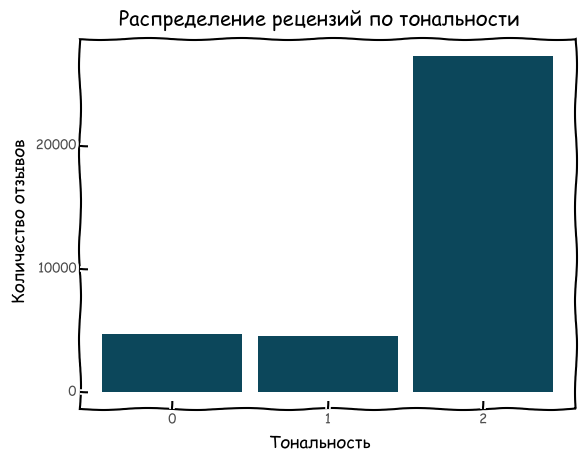

<ggplot: (170121172432)>

In [5]:
(
    ggplot(df_norm) 
    + aes(x='grade',
          color='grade',
          fill='grade')
    + geom_bar(fill='#0C475B', show_legend=True)
    + theme_xkcd()
    + ggtitle('Распределение рецензий по тональности')
    + xlab('Тональность')
    + ylab('Количество отзывов')
)

В plotnine ней piechart'ов, поэтому воспользуемся matplotlib

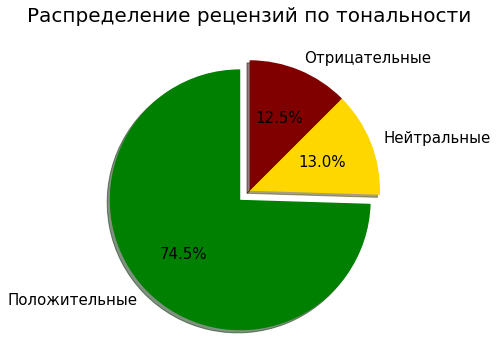

In [6]:
df_norm.grade.value_counts().plot(kind='pie', 
                                  autopct='%1.1f%%', 
                                  colors=['#008000', '#FFD700', '#800000'],
                                  labels=['Положительные', 'Нейтральные', 'Отрицательные'],
                                  figsize=(8,6),
                                  fontsize=15,
                                  startangle=90,
                                  explode = (0.1, 0, 0),
                                  shadow=True)
plt.axis('off')
plt.title('Распределение рецензий по тональности', fontsize = 20)
plt.show()

In [7]:
df_norm.grade.value_counts()

2    27264
0     4751
1     4576
Name: grade, dtype: int64

In [5]:
df_norm.dropna(inplace=True)
df_norm.grade.value_counts()

2    27264
0     4751
1     4576
Name: grade, dtype: int64

In [10]:
# Сбалансируем классы в датасете
neg = df_norm[df_norm.grade == 0]
neu = df_norm[df_norm.grade == 1]
pos = df_norm[df_norm.grade == 2].sample(n=5000)
df_bal = pd.concat([neg,neu,pos], axis=0)
df_bal.sample(10)

,grade,lemmas
35373,0,"['решить', 'посмотреть', 'фильм', 'сказать', '..."
32481,1,"['цитата', 'озаглавить', 'рецензия', 'принадле..."
32584,0,"['знать', 'писать', 'столько', 'переполнять', ..."
34400,0,"['говорить', 'классик', 'женщина', 'хороший', ..."
211,2,"['честно', 'говорить', 'думать', 'давно', 'выр..."
30792,1,"['голов', 'сумасшедший', 'вывод', 'свой', 'сум..."
7045,2,"['говорить', 'дэвид', 'линч', 'гений', 'извест..."
25911,2,"['фильм', 'появление', 'ознаменовать', 'важный..."
11869,2,"['увидеть', 'фильм', 'пошлый', 'год', 'первое'..."
35020,0,"['посмотреть', 'свой', 'голова', 'слава', 'бог..."


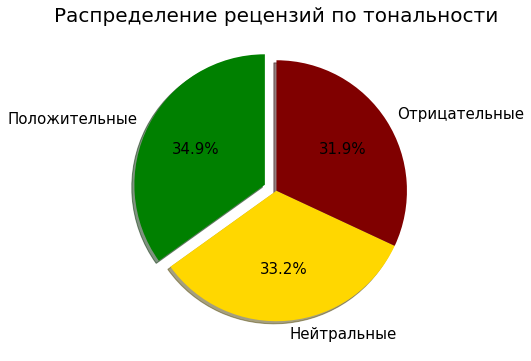

In [11]:
df_bal.grade.value_counts().plot(kind='pie', 
                                  autopct='%1.1f%%', 
                                  colors=['#008000', '#FFD700', '#800000'],
                                  labels=['Положительные', 'Нейтральные', 'Отрицательные'],
                                  figsize=(8,6),
                                  fontsize=15,
                                  startangle=90,
                                  explode = (0.1, 0, 0),
                                  shadow=True)
plt.axis('off')
plt.title('Распределение рецензий по тональности', fontsize = 20)
plt.show()

In [87]:
df_bal.shape

(14327, 2)

In [88]:
df_bal.isna().any()

grade     False
lemmas    False
dtype: bool

In [89]:
# Векторизация
tfidf_vec = TfidfVectorizer(max_features=20000, 
                            use_idf=True)

In [90]:
X = df_bal.loc[:, 'lemmas']
y = df_bal.loc[:, 'grade']

In [91]:
X.shape

(14327,)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=1234)

In [93]:
xtrain_tfidf = tfidf_vec.fit_transform(X_train)
xtest_tfidf = tfidf_vec.transform(X_test)

xtrain_tfidf.shape

(10028, 20000)

# Тренировка моделей

In [94]:
# Создание списка моделей и метрик оценки
perform_list = []

In [ ]:
def run_model(model_name, *args, **kwargs):
    mdl=''
    
    if model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()
    elif model_name == 'Multinomial Naive Bayes+':
        mdl = MultinomialNB(**kwargs)
    
    elif model_name == 'SVC':
        mdl = SVC(gamma='auto')
    elif model_name == 'SVC+':
        mdl = SVC()
        mdl.set_params(**kwargs)
    
    elif model_name == 'Logistic Regression':
        mdl = LogisticRegression()    
    elif model_name == 'Logistic Regression+':
        mdl = LogisticRegression()
        mdl.set_params(**kwargs)
        
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100)
    elif model_name == 'Random Forest+':
        mdl = RandomForestClassifier()
        mdl.set_params(**kwargs)  
        
    elif model_name == 'Gradient Boosting':
        mdl = GradientBoostingClassifier()
    elif model_name == 'Gradient Boosting+':
        mdl = GradientBoostingClassifier()
        mdl.set_params(**kwargs)
        
    elif model_name == 'KNN':
        mdl = KNeighborsClassifier()
    elif model_name == 'KNN+':
        mdl = KNeighborsClassifier()
        mdl.set_params(**kwargs)
        
    elif model_name == 'XGBoost':
        mdl = XGBClassifier()
    elif model_name == 'XGBoost+':
        mdl = XGBClassifier()
        mdl.set_params(**kwargs)
        
    elif model_name == 'Cat Boost':
        mdl = CatBoostClassifier(iterations=2000,
                                 learning_rate=1,
                                 depth=2,
                                 loss_function='MultiClass')
    elif model_name == 'Cat Boost+':
        mdl = CatBoostClassifier()
        mdl.set_params(iterations=2000,
                       loss_function='MultiClass',
                       **kwargs) 

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(xtrain_tfidf, y_train)
    y_pred = oneVsRest.predict(xtest_tfidf)
    
    
    # Метрики оценки
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Точность модели \"{model_name}\" составляет {accuracy} %',
         '\n\n',
         classification_report(y_test, y_pred))

    # Добавляем результаты в ранее созданный список
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))
    
    #Сохраняем модель
    #pickle.dump(mdl, f'{model_name}.sav')

Датасет Кинопоиска давольно объемный, поэтому для поиска оптимальных параметров воспользуемся RandomizedSearch, а не GridSearch

In [134]:
def find_best_params(model_name, model_params):
    mdl = ''
    if model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()      
    elif model_name == 'SVC':
        mdl = SVC()   
    elif model_name == 'Logistic Regression':
        mdl = LogisticRegression()           
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier()         
    elif model_name == 'Gradient Boosting':
        mdl = GradientBoostingClassifier()
    elif model_name == 'KNN':
        mdl = KNeighborsClassifier()
    elif model_name == 'XGBoost':
        mdl = XGBClassifier()
    elif model_name == 'Cat Boost':
        mdl = CatBoostClassifier(iterations= 2000,
                                 loss_function= 'MultiClass')
    
    rs = RandomizedSearchCV(mdl,
                            model_params,
                            n_iter = 100,
                            cv = 3, 
                            verbose = 1, 
                            n_jobs = -1, 
                            random_state = 0)
    rs.fit(xtrain_tfidf, y_train)
    return rs.best_params_
    

## Multinomial Naive Bayes

In [101]:
run_model('Multinomial Naive Bayes')

Точность модели "Multinomial Naive Bayes" составляет 62.25 % 

               precision    recall  f1-score   support

           0       0.68      0.77      0.72      1421
           1       0.53      0.15      0.24      1363
           2       0.60      0.91      0.72      1515

    accuracy                           0.62      4299
   macro avg       0.60      0.61      0.56      4299
weighted avg       0.60      0.62      0.57      4299



In [102]:
param_nb = {
    'alpha': np.arange(1/100000, 20, 0.11),
}

In [103]:
nb_best_params = find_best_params('Multinomial Naive Bayes',
                                  param_nb)
nb_best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'alpha': 0.22001}

In [104]:
run_model('Multinomial Naive Bayes+', nb_best_params)

Точность модели "Multinomial Naive Bayes+" составляет 62.25 % 

               precision    recall  f1-score   support

           0       0.68      0.77      0.72      1421
           1       0.53      0.15      0.24      1363
           2       0.60      0.91      0.72      1515

    accuracy                           0.62      4299
   macro avg       0.60      0.61      0.56      4299
weighted avg       0.60      0.62      0.57      4299



## SVC

In [105]:
run_model('SVC')

Точность модели "SVC" составляет 61.55 % 

               precision    recall  f1-score   support

           0       0.62      0.90      0.73      1421
           1       0.73      0.01      0.03      1363
           2       0.61      0.89      0.73      1515

    accuracy                           0.62      4299
   macro avg       0.65      0.60      0.50      4299
weighted avg       0.65      0.62      0.51      4299



In [106]:
param_sv = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [int(x) for x in np.linspace(0, 6, 7)]
    
} 

In [107]:
sv_best_params = find_best_params('SVC',
                                  param_sv)
sv_best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 1}

In [108]:
run_model('SVC+', sv_best_params)

Точность модели "SVC+" составляет 66.95 % 

               precision    recall  f1-score   support

           0       0.71      0.83      0.77      1421
           1       0.57      0.31      0.40      1363
           2       0.67      0.84      0.75      1515

    accuracy                           0.67      4299
   macro avg       0.65      0.66      0.64      4299
weighted avg       0.65      0.67      0.64      4299



## Logistic Regression

In [110]:
run_model('Logistic Regression')

Точность модели "Logistic Regression" составляет 66.76 % 

               precision    recall  f1-score   support

           0       0.73      0.78      0.76      1421
           1       0.53      0.41      0.46      1363
           2       0.69      0.79      0.74      1515

    accuracy                           0.67      4299
   macro avg       0.65      0.66      0.65      4299
weighted avg       0.65      0.67      0.66      4299



In [111]:
param_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [20, 50, 100, 200, 500, 1000]
}

In [112]:
lr_best_params = find_best_params('Logistic Regression',
                                  param_lr)
lr_best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\alice\appdata\local\programs\python

{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 20, 'C': 1}

In [113]:
run_model('Logistic Regression+', lr_best_params)

Точность модели "Logistic Regression+" составляет 66.76 % 

               precision    recall  f1-score   support

           0       0.73      0.78      0.76      1421
           1       0.53      0.41      0.46      1363
           2       0.69      0.79      0.74      1515

    accuracy                           0.67      4299
   macro avg       0.65      0.66      0.65      4299
weighted avg       0.65      0.67      0.66      4299



## Random Forest

In [114]:
run_model('Random Forest')

Точность модели "Random Forest" составляет 63.97 % 

               precision    recall  f1-score   support

           0       0.68      0.80      0.73      1421
           1       0.54      0.27      0.36      1363
           2       0.65      0.82      0.72      1515

    accuracy                           0.64      4299
   macro avg       0.62      0.63      0.60      4299
weighted avg       0.62      0.64      0.61      4299



In [115]:
param_rf = {
    'n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [int(x) for x in np.linspace(1, 15, 15)],
    'min_samples_split': [int(x) for x in np.linspace(2, 50, 10)],
    'min_samples_leaf': [int(x) for x in np.linspace(2, 50, 10)],
    'max_features': ['log2', 'sqrt'],
    'bootstrap': [True, False]
}

In [117]:
rf_best_params = find_best_params('Random Forest',
                                  param_rf)
rf_best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
117 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
51 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", 

{'n_estimators': 800,
 'min_samples_split': 28,
 'min_samples_leaf': 12,
 'max_features': 'sqrt',
 'max_depth': 14,
 'criterion': 'gini',
 'bootstrap': True}

In [118]:
run_model('Random Forest+', rf_best_params)

Точность модели "Random Forest+" составляет 63.64 % 

               precision    recall  f1-score   support

           0       0.68      0.79      0.73      1421
           1       0.52      0.27      0.36      1363
           2       0.64      0.83      0.72      1515

    accuracy                           0.64      4299
   macro avg       0.61      0.63      0.60      4299
weighted avg       0.62      0.64      0.61      4299



## Gardient Boosting

In [119]:
run_model('Gradient Boosting')

Точность модели "Gradient Boosting" составляет 62.06 % 

               precision    recall  f1-score   support

           0       0.67      0.71      0.69      1421
           1       0.49      0.37      0.42      1363
           2       0.65      0.77      0.70      1515

    accuracy                           0.62      4299
   macro avg       0.60      0.61      0.60      4299
weighted avg       0.61      0.62      0.61      4299



In [120]:
param_gb = {
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200, 500, 1000],
    'min_samples_split': np.linspace(0.1, 1.0, 10),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5),
    'max_depth': [int(x) for x in np.linspace(1, 32, 32)],
    'max_features': [int(x) for x in np.arange(7, 20, 2)],
}

In [121]:
gb_best_params = find_best_params('Gradient Boosting',
                                  param_gb)
gb_best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 500,
 'min_samples_split': 0.1,
 'min_samples_leaf': 0.1,
 'max_features': 13,
 'max_depth': 3,
 'learning_rate': 1}

In [122]:
run_model('Gradient Boosting+', gb_best_params)

Точность модели "Gradient Boosting+" составляет 62.08 % 

               precision    recall  f1-score   support

           0       0.67      0.71      0.69      1421
           1       0.49      0.37      0.42      1363
           2       0.65      0.77      0.70      1515

    accuracy                           0.62      4299
   macro avg       0.61      0.61      0.61      4299
weighted avg       0.61      0.62      0.61      4299



## KNN

In [123]:
run_model('KNN')

Точность модели "KNN" составляет 51.17 % 

               precision    recall  f1-score   support

           0       0.73      0.43      0.54      1421
           1       0.39      0.17      0.23      1363
           2       0.47      0.90      0.62      1515

    accuracy                           0.51      4299
   macro avg       0.53      0.50      0.46      4299
weighted avg       0.53      0.51      0.47      4299



In [124]:
param_knn = {
    'n_neighbors': [int(x) for x in np.linspace(1, 30, 30)],
    'p': [int(x) for x in np.linspace(1, 5, 5)],
    'leaf_size': [int(x) for x in np.linspace(1, 50, 50)]
}

In [125]:
knn_best_params = find_best_params('KNN',
                                   param_knn)
knn_best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
186 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
186 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit
    return self._fit(X, y)
  File "c:\users\alice\appdata\local\programs\python\python38\lib\site-packages\sklear

{'p': 2, 'n_neighbors': 29, 'leaf_size': 47}

In [126]:
run_model('KNN+', knn_best_params)

Точность модели "KNN+" составляет 51.17 % 

               precision    recall  f1-score   support

           0       0.73      0.43      0.54      1421
           1       0.39      0.17      0.23      1363
           2       0.47      0.90      0.62      1515

    accuracy                           0.51      4299
   macro avg       0.53      0.50      0.46      4299
weighted avg       0.53      0.51      0.47      4299



## XGBoost

In [127]:
run_model('XGBoost')

Точность модели "XGBoost" составляет 63.67 % 

               precision    recall  f1-score   support

           0       0.70      0.73      0.71      1421
           1       0.50      0.41      0.45      1363
           2       0.68      0.75      0.71      1515

    accuracy                           0.64      4299
   macro avg       0.62      0.63      0.63      4299
weighted avg       0.63      0.64      0.63      4299



In [128]:
param_xgb = {
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'gamma': np.arange(0, 1, 0.25),
    'reg_lamdba': np.arange(0, 1, 0.1),
    'reg_alpha': np.arange(0, 1, 0.1),
    'max_depth': [int(x) for x in np.linspace(1, 10, 10)],
    'subsample': np.arange(0, 1, 0.1),
    'colsample_bytree': np.arange(0, 1, 0.1)
}

In [129]:
xgb_best_params = find_best_params('XGBoost',
                                   param_xgb)
xgb_best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[10:41:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamdba" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




{'subsample': 0.4,
 'reg_lamdba': 0.2,
 'reg_alpha': 0.2,
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 0.75,
 'colsample_bytree': 0.5}

In [130]:
run_model('XGBoost+', xgb_best_params)

Точность модели "XGBoost+" составляет 63.67 % 

               precision    recall  f1-score   support

           0       0.70      0.73      0.71      1421
           1       0.50      0.41      0.45      1363
           2       0.68      0.75      0.71      1515

    accuracy                           0.64      4299
   macro avg       0.62      0.63      0.63      4299
weighted avg       0.63      0.64      0.63      4299



## CatBoost

In [131]:
run_model('Cat Boost')

0:	learn: 0.6051300	total: 399ms	remaining: 13m 16s
1:	learn: 0.5803051	total: 591ms	remaining: 9m 50s
2:	learn: 0.5624043	total: 786ms	remaining: 8m 43s
3:	learn: 0.5507778	total: 983ms	remaining: 8m 10s
4:	learn: 0.5358361	total: 1.23s	remaining: 8m 9s
5:	learn: 0.5244194	total: 1.42s	remaining: 7m 52s
6:	learn: 0.5166674	total: 1.66s	remaining: 7m 51s
7:	learn: 0.5104726	total: 1.85s	remaining: 7m 41s
8:	learn: 0.5025578	total: 2.06s	remaining: 7m 35s
9:	learn: 0.4972983	total: 2.27s	remaining: 7m 31s
10:	learn: 0.4913747	total: 2.46s	remaining: 7m 24s
11:	learn: 0.4865429	total: 2.68s	remaining: 7m 24s
12:	learn: 0.4829129	total: 2.88s	remaining: 7m 20s
13:	learn: 0.4788876	total: 3.09s	remaining: 7m 18s
14:	learn: 0.4738768	total: 3.29s	remaining: 7m 15s
15:	learn: 0.4708048	total: 3.51s	remaining: 7m 15s
16:	learn: 0.4686015	total: 3.71s	remaining: 7m 13s
17:	learn: 0.4657726	total: 3.91s	remaining: 7m 10s
18:	learn: 0.4626728	total: 4.12s	remaining: 7m 9s
19:	learn: 0.4581440	to

160:	learn: 0.3157566	total: 30.4s	remaining: 5m 47s
161:	learn: 0.3151881	total: 30.6s	remaining: 5m 47s
162:	learn: 0.3144534	total: 30.8s	remaining: 5m 46s
163:	learn: 0.3137277	total: 31s	remaining: 5m 46s
164:	learn: 0.3133110	total: 31.2s	remaining: 5m 46s
165:	learn: 0.3130358	total: 31.3s	remaining: 5m 46s
166:	learn: 0.3127033	total: 31.5s	remaining: 5m 45s
167:	learn: 0.3120089	total: 31.7s	remaining: 5m 45s
168:	learn: 0.3115761	total: 31.9s	remaining: 5m 45s
169:	learn: 0.3113069	total: 32.1s	remaining: 5m 45s
170:	learn: 0.3109147	total: 32.3s	remaining: 5m 44s
171:	learn: 0.3100623	total: 32.4s	remaining: 5m 44s
172:	learn: 0.3093240	total: 32.6s	remaining: 5m 44s
173:	learn: 0.3089093	total: 32.8s	remaining: 5m 44s
174:	learn: 0.3084376	total: 33s	remaining: 5m 43s
175:	learn: 0.3082208	total: 33.2s	remaining: 5m 43s
176:	learn: 0.3078441	total: 33.3s	remaining: 5m 43s
177:	learn: 0.3075420	total: 33.5s	remaining: 5m 43s
178:	learn: 0.3073989	total: 33.7s	remaining: 5m 4

317:	learn: 0.2557375	total: 59.6s	remaining: 5m 15s
318:	learn: 0.2552244	total: 59.8s	remaining: 5m 15s
319:	learn: 0.2547989	total: 1m	remaining: 5m 15s
320:	learn: 0.2541500	total: 1m	remaining: 5m 15s
321:	learn: 0.2540841	total: 1m	remaining: 5m 14s
322:	learn: 0.2537988	total: 1m	remaining: 5m 14s
323:	learn: 0.2533609	total: 1m	remaining: 5m 14s
324:	learn: 0.2530540	total: 1m 1s	remaining: 5m 14s
325:	learn: 0.2527222	total: 1m 1s	remaining: 5m 14s
326:	learn: 0.2525846	total: 1m 1s	remaining: 5m 14s
327:	learn: 0.2521972	total: 1m 1s	remaining: 5m 13s
328:	learn: 0.2519286	total: 1m 1s	remaining: 5m 13s
329:	learn: 0.2514775	total: 1m 1s	remaining: 5m 13s
330:	learn: 0.2510428	total: 1m 2s	remaining: 5m 13s
331:	learn: 0.2501855	total: 1m 2s	remaining: 5m 13s
332:	learn: 0.2498437	total: 1m 2s	remaining: 5m 13s
333:	learn: 0.2493035	total: 1m 2s	remaining: 5m 12s
334:	learn: 0.2488941	total: 1m 2s	remaining: 5m 12s
335:	learn: 0.2484850	total: 1m 3s	remaining: 5m 12s
336:	lea

472:	learn: 0.2156199	total: 1m 28s	remaining: 4m 46s
473:	learn: 0.2154762	total: 1m 28s	remaining: 4m 45s
474:	learn: 0.2150794	total: 1m 28s	remaining: 4m 45s
475:	learn: 0.2149163	total: 1m 29s	remaining: 4m 45s
476:	learn: 0.2147124	total: 1m 29s	remaining: 4m 45s
477:	learn: 0.2145160	total: 1m 29s	remaining: 4m 45s
478:	learn: 0.2144136	total: 1m 29s	remaining: 4m 44s
479:	learn: 0.2143062	total: 1m 29s	remaining: 4m 44s
480:	learn: 0.2141174	total: 1m 30s	remaining: 4m 44s
481:	learn: 0.2139487	total: 1m 30s	remaining: 4m 44s
482:	learn: 0.2138216	total: 1m 30s	remaining: 4m 44s
483:	learn: 0.2136794	total: 1m 30s	remaining: 4m 43s
484:	learn: 0.2134535	total: 1m 30s	remaining: 4m 43s
485:	learn: 0.2133177	total: 1m 30s	remaining: 4m 43s
486:	learn: 0.2131780	total: 1m 31s	remaining: 4m 43s
487:	learn: 0.2130690	total: 1m 31s	remaining: 4m 43s
488:	learn: 0.2128974	total: 1m 31s	remaining: 4m 42s
489:	learn: 0.2124676	total: 1m 31s	remaining: 4m 42s
490:	learn: 0.2122768	total:

625:	learn: 0.1876095	total: 1m 56s	remaining: 4m 16s
626:	learn: 0.1875493	total: 1m 57s	remaining: 4m 16s
627:	learn: 0.1874126	total: 1m 57s	remaining: 4m 16s
628:	learn: 0.1872885	total: 1m 57s	remaining: 4m 16s
629:	learn: 0.1872154	total: 1m 57s	remaining: 4m 15s
630:	learn: 0.1870666	total: 1m 57s	remaining: 4m 15s
631:	learn: 0.1869440	total: 1m 58s	remaining: 4m 15s
632:	learn: 0.1867642	total: 1m 58s	remaining: 4m 15s
633:	learn: 0.1865205	total: 1m 58s	remaining: 4m 15s
634:	learn: 0.1863906	total: 1m 58s	remaining: 4m 15s
635:	learn: 0.1862211	total: 1m 58s	remaining: 4m 14s
636:	learn: 0.1861593	total: 1m 58s	remaining: 4m 14s
637:	learn: 0.1860289	total: 1m 59s	remaining: 4m 14s
638:	learn: 0.1858318	total: 1m 59s	remaining: 4m 14s
639:	learn: 0.1857247	total: 1m 59s	remaining: 4m 14s
640:	learn: 0.1855037	total: 1m 59s	remaining: 4m 13s
641:	learn: 0.1854405	total: 1m 59s	remaining: 4m 13s
642:	learn: 0.1852258	total: 2m	remaining: 4m 13s
643:	learn: 0.1849064	total: 2m	

780:	learn: 0.1662849	total: 2m 26s	remaining: 3m 49s
781:	learn: 0.1662439	total: 2m 26s	remaining: 3m 48s
782:	learn: 0.1658752	total: 2m 27s	remaining: 3m 48s
783:	learn: 0.1656537	total: 2m 27s	remaining: 3m 48s
784:	learn: 0.1655156	total: 2m 27s	remaining: 3m 48s
785:	learn: 0.1654432	total: 2m 27s	remaining: 3m 48s
786:	learn: 0.1652109	total: 2m 27s	remaining: 3m 47s
787:	learn: 0.1650416	total: 2m 28s	remaining: 3m 47s
788:	learn: 0.1647615	total: 2m 28s	remaining: 3m 47s
789:	learn: 0.1646784	total: 2m 28s	remaining: 3m 47s
790:	learn: 0.1644566	total: 2m 28s	remaining: 3m 47s
791:	learn: 0.1642528	total: 2m 28s	remaining: 3m 46s
792:	learn: 0.1641607	total: 2m 28s	remaining: 3m 46s
793:	learn: 0.1640850	total: 2m 29s	remaining: 3m 46s
794:	learn: 0.1639516	total: 2m 29s	remaining: 3m 46s
795:	learn: 0.1638868	total: 2m 29s	remaining: 3m 46s
796:	learn: 0.1637594	total: 2m 29s	remaining: 3m 45s
797:	learn: 0.1635762	total: 2m 29s	remaining: 3m 45s
798:	learn: 0.1634459	total:

932:	learn: 0.1486559	total: 2m 54s	remaining: 3m 20s
933:	learn: 0.1484630	total: 2m 55s	remaining: 3m 19s
934:	learn: 0.1484000	total: 2m 55s	remaining: 3m 19s
935:	learn: 0.1482609	total: 2m 55s	remaining: 3m 19s
936:	learn: 0.1481317	total: 2m 55s	remaining: 3m 19s
937:	learn: 0.1480890	total: 2m 55s	remaining: 3m 19s
938:	learn: 0.1479438	total: 2m 56s	remaining: 3m 18s
939:	learn: 0.1478549	total: 2m 56s	remaining: 3m 18s
940:	learn: 0.1477656	total: 2m 56s	remaining: 3m 18s
941:	learn: 0.1476810	total: 2m 56s	remaining: 3m 18s
942:	learn: 0.1476503	total: 2m 56s	remaining: 3m 18s
943:	learn: 0.1475501	total: 2m 56s	remaining: 3m 17s
944:	learn: 0.1474533	total: 2m 57s	remaining: 3m 17s
945:	learn: 0.1473092	total: 2m 57s	remaining: 3m 17s
946:	learn: 0.1471739	total: 2m 57s	remaining: 3m 17s
947:	learn: 0.1471405	total: 2m 57s	remaining: 3m 17s
948:	learn: 0.1470074	total: 2m 57s	remaining: 3m 16s
949:	learn: 0.1468137	total: 2m 58s	remaining: 3m 16s
950:	learn: 0.1467504	total:

1086:	learn: 0.1328483	total: 3m 23s	remaining: 2m 50s
1087:	learn: 0.1325461	total: 3m 23s	remaining: 2m 50s
1088:	learn: 0.1324828	total: 3m 23s	remaining: 2m 50s
1089:	learn: 0.1324301	total: 3m 24s	remaining: 2m 50s
1090:	learn: 0.1321244	total: 3m 24s	remaining: 2m 50s
1091:	learn: 0.1320160	total: 3m 24s	remaining: 2m 49s
1092:	learn: 0.1319885	total: 3m 24s	remaining: 2m 49s
1093:	learn: 0.1318768	total: 3m 24s	remaining: 2m 49s
1094:	learn: 0.1317332	total: 3m 25s	remaining: 2m 49s
1095:	learn: 0.1316499	total: 3m 25s	remaining: 2m 49s
1096:	learn: 0.1314780	total: 3m 25s	remaining: 2m 49s
1097:	learn: 0.1313995	total: 3m 25s	remaining: 2m 48s
1098:	learn: 0.1313184	total: 3m 25s	remaining: 2m 48s
1099:	learn: 0.1312398	total: 3m 25s	remaining: 2m 48s
1100:	learn: 0.1311275	total: 3m 26s	remaining: 2m 48s
1101:	learn: 0.1310801	total: 3m 26s	remaining: 2m 48s
1102:	learn: 0.1309597	total: 3m 26s	remaining: 2m 47s
1103:	learn: 0.1308250	total: 3m 26s	remaining: 2m 47s
1104:	lear

1236:	learn: 0.1196602	total: 3m 51s	remaining: 2m 22s
1237:	learn: 0.1193810	total: 3m 51s	remaining: 2m 22s
1238:	learn: 0.1192658	total: 3m 51s	remaining: 2m 22s
1239:	learn: 0.1191766	total: 3m 52s	remaining: 2m 22s
1240:	learn: 0.1190770	total: 3m 52s	remaining: 2m 22s
1241:	learn: 0.1189916	total: 3m 52s	remaining: 2m 21s
1242:	learn: 0.1188522	total: 3m 52s	remaining: 2m 21s
1243:	learn: 0.1186609	total: 3m 52s	remaining: 2m 21s
1244:	learn: 0.1186084	total: 3m 52s	remaining: 2m 21s
1245:	learn: 0.1185786	total: 3m 53s	remaining: 2m 21s
1246:	learn: 0.1185057	total: 3m 53s	remaining: 2m 20s
1247:	learn: 0.1184434	total: 3m 53s	remaining: 2m 20s
1248:	learn: 0.1183351	total: 3m 53s	remaining: 2m 20s
1249:	learn: 0.1182005	total: 3m 53s	remaining: 2m 20s
1250:	learn: 0.1181775	total: 3m 54s	remaining: 2m 20s
1251:	learn: 0.1180470	total: 3m 54s	remaining: 2m 19s
1252:	learn: 0.1179073	total: 3m 54s	remaining: 2m 19s
1253:	learn: 0.1178304	total: 3m 54s	remaining: 2m 19s
1254:	lear

1389:	learn: 0.1084322	total: 4m 20s	remaining: 1m 54s
1390:	learn: 0.1083313	total: 4m 20s	remaining: 1m 53s
1391:	learn: 0.1082789	total: 4m 20s	remaining: 1m 53s
1392:	learn: 0.1081640	total: 4m 20s	remaining: 1m 53s
1393:	learn: 0.1081250	total: 4m 20s	remaining: 1m 53s
1394:	learn: 0.1080266	total: 4m 20s	remaining: 1m 53s
1395:	learn: 0.1079642	total: 4m 21s	remaining: 1m 52s
1396:	learn: 0.1079150	total: 4m 21s	remaining: 1m 52s
1397:	learn: 0.1078783	total: 4m 21s	remaining: 1m 52s
1398:	learn: 0.1078163	total: 4m 21s	remaining: 1m 52s
1399:	learn: 0.1077719	total: 4m 21s	remaining: 1m 52s
1400:	learn: 0.1076916	total: 4m 22s	remaining: 1m 52s
1401:	learn: 0.1076027	total: 4m 22s	remaining: 1m 51s
1402:	learn: 0.1075346	total: 4m 22s	remaining: 1m 51s
1403:	learn: 0.1075151	total: 4m 22s	remaining: 1m 51s
1404:	learn: 0.1074510	total: 4m 22s	remaining: 1m 51s
1405:	learn: 0.1074329	total: 4m 22s	remaining: 1m 51s
1406:	learn: 0.1073951	total: 4m 23s	remaining: 1m 50s
1407:	lear

1539:	learn: 0.0995742	total: 4m 47s	remaining: 1m 25s
1540:	learn: 0.0995461	total: 4m 47s	remaining: 1m 25s
1541:	learn: 0.0995231	total: 4m 48s	remaining: 1m 25s
1542:	learn: 0.0994418	total: 4m 48s	remaining: 1m 25s
1543:	learn: 0.0994157	total: 4m 48s	remaining: 1m 25s
1544:	learn: 0.0993907	total: 4m 48s	remaining: 1m 24s
1545:	learn: 0.0993615	total: 4m 48s	remaining: 1m 24s
1546:	learn: 0.0993204	total: 4m 48s	remaining: 1m 24s
1547:	learn: 0.0992872	total: 4m 49s	remaining: 1m 24s
1548:	learn: 0.0991945	total: 4m 49s	remaining: 1m 24s
1549:	learn: 0.0991728	total: 4m 49s	remaining: 1m 24s
1550:	learn: 0.0991166	total: 4m 49s	remaining: 1m 23s
1551:	learn: 0.0990517	total: 4m 49s	remaining: 1m 23s
1552:	learn: 0.0990375	total: 4m 50s	remaining: 1m 23s
1553:	learn: 0.0990121	total: 4m 50s	remaining: 1m 23s
1554:	learn: 0.0990018	total: 4m 50s	remaining: 1m 23s
1555:	learn: 0.0989753	total: 4m 50s	remaining: 1m 22s
1556:	learn: 0.0989300	total: 4m 50s	remaining: 1m 22s
1557:	lear

1692:	learn: 0.0909512	total: 5m 15s	remaining: 57.3s
1693:	learn: 0.0908640	total: 5m 16s	remaining: 57.1s
1694:	learn: 0.0908204	total: 5m 16s	remaining: 56.9s
1695:	learn: 0.0907951	total: 5m 16s	remaining: 56.7s
1696:	learn: 0.0907652	total: 5m 16s	remaining: 56.5s
1697:	learn: 0.0907296	total: 5m 16s	remaining: 56.3s
1698:	learn: 0.0906871	total: 5m 16s	remaining: 56.1s
1699:	learn: 0.0905851	total: 5m 17s	remaining: 56s
1700:	learn: 0.0905328	total: 5m 17s	remaining: 55.8s
1701:	learn: 0.0904772	total: 5m 17s	remaining: 55.6s
1702:	learn: 0.0904263	total: 5m 17s	remaining: 55.4s
1703:	learn: 0.0903570	total: 5m 17s	remaining: 55.2s
1704:	learn: 0.0902322	total: 5m 18s	remaining: 55s
1705:	learn: 0.0901208	total: 5m 18s	remaining: 54.8s
1706:	learn: 0.0900988	total: 5m 18s	remaining: 54.6s
1707:	learn: 0.0900524	total: 5m 18s	remaining: 54.5s
1708:	learn: 0.0900113	total: 5m 18s	remaining: 54.3s
1709:	learn: 0.0899897	total: 5m 18s	remaining: 54.1s
1710:	learn: 0.0898466	total: 5m

1846:	learn: 0.0836469	total: 5m 44s	remaining: 28.5s
1847:	learn: 0.0836201	total: 5m 44s	remaining: 28.3s
1848:	learn: 0.0836100	total: 5m 44s	remaining: 28.1s
1849:	learn: 0.0835793	total: 5m 44s	remaining: 28s
1850:	learn: 0.0835251	total: 5m 44s	remaining: 27.8s
1851:	learn: 0.0835001	total: 5m 45s	remaining: 27.6s
1852:	learn: 0.0834620	total: 5m 45s	remaining: 27.4s
1853:	learn: 0.0833909	total: 5m 45s	remaining: 27.2s
1854:	learn: 0.0833133	total: 5m 45s	remaining: 27s
1855:	learn: 0.0832799	total: 5m 45s	remaining: 26.8s
1856:	learn: 0.0832479	total: 5m 46s	remaining: 26.6s
1857:	learn: 0.0832229	total: 5m 46s	remaining: 26.5s
1858:	learn: 0.0829858	total: 5m 46s	remaining: 26.3s
1859:	learn: 0.0829235	total: 5m 46s	remaining: 26.1s
1860:	learn: 0.0828826	total: 5m 46s	remaining: 25.9s
1861:	learn: 0.0828041	total: 5m 46s	remaining: 25.7s
1862:	learn: 0.0827841	total: 5m 47s	remaining: 25.5s
1863:	learn: 0.0827472	total: 5m 47s	remaining: 25.3s
1864:	learn: 0.0827245	total: 5m

0:	learn: 0.6255587	total: 215ms	remaining: 7m 9s
1:	learn: 0.6231134	total: 406ms	remaining: 6m 45s
2:	learn: 0.6184606	total: 592ms	remaining: 6m 34s
3:	learn: 0.6148724	total: 789ms	remaining: 6m 33s
4:	learn: 0.6111508	total: 977ms	remaining: 6m 29s
5:	learn: 0.6074169	total: 1.17s	remaining: 6m 28s
6:	learn: 0.6057189	total: 1.35s	remaining: 6m 23s
7:	learn: 0.6043249	total: 1.53s	remaining: 6m 22s
8:	learn: 0.6020788	total: 1.75s	remaining: 6m 26s
9:	learn: 0.5993559	total: 1.93s	remaining: 6m 25s
10:	learn: 0.5964709	total: 2.13s	remaining: 6m 24s
11:	learn: 0.5945881	total: 2.31s	remaining: 6m 22s
12:	learn: 0.5934545	total: 2.49s	remaining: 6m 21s
13:	learn: 0.5909442	total: 2.67s	remaining: 6m 19s
14:	learn: 0.5884197	total: 2.86s	remaining: 6m 18s
15:	learn: 0.5864751	total: 3.07s	remaining: 6m 21s
16:	learn: 0.5843342	total: 3.26s	remaining: 6m 20s
17:	learn: 0.5837927	total: 3.45s	remaining: 6m 20s
18:	learn: 0.5828849	total: 3.63s	remaining: 6m 19s
19:	learn: 0.5818595	to

158:	learn: 0.4818259	total: 29.7s	remaining: 5m 43s
159:	learn: 0.4812079	total: 29.8s	remaining: 5m 43s
160:	learn: 0.4807353	total: 30s	remaining: 5m 42s
161:	learn: 0.4801551	total: 30.2s	remaining: 5m 42s
162:	learn: 0.4797935	total: 30.4s	remaining: 5m 42s
163:	learn: 0.4795334	total: 30.6s	remaining: 5m 42s
164:	learn: 0.4787432	total: 30.8s	remaining: 5m 42s
165:	learn: 0.4783909	total: 30.9s	remaining: 5m 41s
166:	learn: 0.4778426	total: 31.1s	remaining: 5m 41s
167:	learn: 0.4772952	total: 31.3s	remaining: 5m 41s
168:	learn: 0.4763853	total: 31.5s	remaining: 5m 41s
169:	learn: 0.4757906	total: 31.7s	remaining: 5m 41s
170:	learn: 0.4754966	total: 31.9s	remaining: 5m 40s
171:	learn: 0.4750371	total: 32s	remaining: 5m 40s
172:	learn: 0.4748274	total: 32.2s	remaining: 5m 40s
173:	learn: 0.4742281	total: 32.4s	remaining: 5m 40s
174:	learn: 0.4735900	total: 32.6s	remaining: 5m 39s
175:	learn: 0.4730406	total: 32.8s	remaining: 5m 39s
176:	learn: 0.4724376	total: 33s	remaining: 5m 39s

315:	learn: 0.4083249	total: 58.7s	remaining: 5m 12s
316:	learn: 0.4078397	total: 58.9s	remaining: 5m 12s
317:	learn: 0.4072705	total: 59s	remaining: 5m 12s
318:	learn: 0.4066389	total: 59.2s	remaining: 5m 12s
319:	learn: 0.4064659	total: 59.4s	remaining: 5m 11s
320:	learn: 0.4061554	total: 59.6s	remaining: 5m 11s
321:	learn: 0.4057501	total: 59.8s	remaining: 5m 11s
322:	learn: 0.4053961	total: 60s	remaining: 5m 11s
323:	learn: 0.4051516	total: 1m	remaining: 5m 11s
324:	learn: 0.4048868	total: 1m	remaining: 5m 10s
325:	learn: 0.4042869	total: 1m	remaining: 5m 10s
326:	learn: 0.4038365	total: 1m	remaining: 5m 10s
327:	learn: 0.4032347	total: 1m	remaining: 5m 10s
328:	learn: 0.4027207	total: 1m 1s	remaining: 5m 10s
329:	learn: 0.4022506	total: 1m 1s	remaining: 5m 9s
330:	learn: 0.4018100	total: 1m 1s	remaining: 5m 9s
331:	learn: 0.4015130	total: 1m 1s	remaining: 5m 9s
332:	learn: 0.4010835	total: 1m 1s	remaining: 5m 9s
333:	learn: 0.4007475	total: 1m 1s	remaining: 5m 9s
334:	learn: 0.400

470:	learn: 0.3529601	total: 1m 27s	remaining: 4m 43s
471:	learn: 0.3527059	total: 1m 27s	remaining: 4m 43s
472:	learn: 0.3523553	total: 1m 27s	remaining: 4m 43s
473:	learn: 0.3520200	total: 1m 27s	remaining: 4m 42s
474:	learn: 0.3516072	total: 1m 28s	remaining: 4m 42s
475:	learn: 0.3514296	total: 1m 28s	remaining: 4m 42s
476:	learn: 0.3510785	total: 1m 28s	remaining: 4m 42s
477:	learn: 0.3509291	total: 1m 28s	remaining: 4m 42s
478:	learn: 0.3507418	total: 1m 28s	remaining: 4m 42s
479:	learn: 0.3504534	total: 1m 29s	remaining: 4m 41s
480:	learn: 0.3501369	total: 1m 29s	remaining: 4m 41s
481:	learn: 0.3497729	total: 1m 29s	remaining: 4m 41s
482:	learn: 0.3494500	total: 1m 29s	remaining: 4m 41s
483:	learn: 0.3493040	total: 1m 29s	remaining: 4m 41s
484:	learn: 0.3490422	total: 1m 29s	remaining: 4m 40s
485:	learn: 0.3488946	total: 1m 30s	remaining: 4m 40s
486:	learn: 0.3488009	total: 1m 30s	remaining: 4m 40s
487:	learn: 0.3487329	total: 1m 30s	remaining: 4m 40s
488:	learn: 0.3485217	total:

623:	learn: 0.3131003	total: 1m 55s	remaining: 4m 15s
624:	learn: 0.3127659	total: 1m 55s	remaining: 4m 15s
625:	learn: 0.3126049	total: 1m 56s	remaining: 4m 15s
626:	learn: 0.3123701	total: 1m 56s	remaining: 4m 14s
627:	learn: 0.3121365	total: 1m 56s	remaining: 4m 14s
628:	learn: 0.3119494	total: 1m 56s	remaining: 4m 14s
629:	learn: 0.3118612	total: 1m 56s	remaining: 4m 14s
630:	learn: 0.3117158	total: 1m 57s	remaining: 4m 14s
631:	learn: 0.3114318	total: 1m 57s	remaining: 4m 13s
632:	learn: 0.3113167	total: 1m 57s	remaining: 4m 13s
633:	learn: 0.3110371	total: 1m 57s	remaining: 4m 13s
634:	learn: 0.3109310	total: 1m 57s	remaining: 4m 13s
635:	learn: 0.3106571	total: 1m 58s	remaining: 4m 13s
636:	learn: 0.3104722	total: 1m 58s	remaining: 4m 12s
637:	learn: 0.3104186	total: 1m 58s	remaining: 4m 12s
638:	learn: 0.3101394	total: 1m 58s	remaining: 4m 12s
639:	learn: 0.3100408	total: 1m 58s	remaining: 4m 12s
640:	learn: 0.3096997	total: 1m 58s	remaining: 4m 12s
641:	learn: 0.3094300	total:

778:	learn: 0.2827556	total: 2m 25s	remaining: 3m 48s
779:	learn: 0.2825656	total: 2m 25s	remaining: 3m 48s
780:	learn: 0.2823784	total: 2m 26s	remaining: 3m 47s
781:	learn: 0.2821964	total: 2m 26s	remaining: 3m 47s
782:	learn: 0.2818765	total: 2m 26s	remaining: 3m 47s
783:	learn: 0.2817163	total: 2m 26s	remaining: 3m 47s
784:	learn: 0.2813991	total: 2m 26s	remaining: 3m 47s
785:	learn: 0.2812441	total: 2m 26s	remaining: 3m 46s
786:	learn: 0.2809602	total: 2m 27s	remaining: 3m 46s
787:	learn: 0.2808125	total: 2m 27s	remaining: 3m 46s
788:	learn: 0.2806785	total: 2m 27s	remaining: 3m 46s
789:	learn: 0.2804849	total: 2m 27s	remaining: 3m 46s
790:	learn: 0.2801503	total: 2m 27s	remaining: 3m 46s
791:	learn: 0.2798474	total: 2m 28s	remaining: 3m 45s
792:	learn: 0.2798108	total: 2m 28s	remaining: 3m 45s
793:	learn: 0.2796754	total: 2m 28s	remaining: 3m 45s
794:	learn: 0.2796151	total: 2m 28s	remaining: 3m 45s
795:	learn: 0.2794984	total: 2m 28s	remaining: 3m 45s
796:	learn: 0.2793549	total:

930:	learn: 0.2548451	total: 2m 54s	remaining: 3m 19s
931:	learn: 0.2546256	total: 2m 54s	remaining: 3m 19s
932:	learn: 0.2544812	total: 2m 54s	remaining: 3m 19s
933:	learn: 0.2543444	total: 2m 54s	remaining: 3m 19s
934:	learn: 0.2542717	total: 2m 54s	remaining: 3m 19s
935:	learn: 0.2541838	total: 2m 54s	remaining: 3m 18s
936:	learn: 0.2541162	total: 2m 55s	remaining: 3m 18s
937:	learn: 0.2539813	total: 2m 55s	remaining: 3m 18s
938:	learn: 0.2538193	total: 2m 55s	remaining: 3m 18s
939:	learn: 0.2536592	total: 2m 55s	remaining: 3m 18s
940:	learn: 0.2534932	total: 2m 55s	remaining: 3m 17s
941:	learn: 0.2533868	total: 2m 56s	remaining: 3m 17s
942:	learn: 0.2533185	total: 2m 56s	remaining: 3m 17s
943:	learn: 0.2531141	total: 2m 56s	remaining: 3m 17s
944:	learn: 0.2528541	total: 2m 56s	remaining: 3m 17s
945:	learn: 0.2527352	total: 2m 56s	remaining: 3m 16s
946:	learn: 0.2525913	total: 2m 56s	remaining: 3m 16s
947:	learn: 0.2525235	total: 2m 57s	remaining: 3m 16s
948:	learn: 0.2523777	total:

1084:	learn: 0.2330054	total: 3m 22s	remaining: 2m 50s
1085:	learn: 0.2329318	total: 3m 22s	remaining: 2m 50s
1086:	learn: 0.2327965	total: 3m 22s	remaining: 2m 50s
1087:	learn: 0.2325548	total: 3m 23s	remaining: 2m 50s
1088:	learn: 0.2324301	total: 3m 23s	remaining: 2m 50s
1089:	learn: 0.2322757	total: 3m 23s	remaining: 2m 49s
1090:	learn: 0.2321879	total: 3m 23s	remaining: 2m 49s
1091:	learn: 0.2320072	total: 3m 23s	remaining: 2m 49s
1092:	learn: 0.2318407	total: 3m 24s	remaining: 2m 49s
1093:	learn: 0.2316536	total: 3m 24s	remaining: 2m 49s
1094:	learn: 0.2315663	total: 3m 24s	remaining: 2m 48s
1095:	learn: 0.2314359	total: 3m 24s	remaining: 2m 48s
1096:	learn: 0.2313091	total: 3m 24s	remaining: 2m 48s
1097:	learn: 0.2311920	total: 3m 25s	remaining: 2m 48s
1098:	learn: 0.2311156	total: 3m 25s	remaining: 2m 48s
1099:	learn: 0.2309889	total: 3m 25s	remaining: 2m 48s
1100:	learn: 0.2309008	total: 3m 25s	remaining: 2m 47s
1101:	learn: 0.2307971	total: 3m 25s	remaining: 2m 47s
1102:	lear

1233:	learn: 0.2139673	total: 3m 50s	remaining: 2m 22s
1234:	learn: 0.2138739	total: 3m 50s	remaining: 2m 22s
1235:	learn: 0.2138368	total: 3m 50s	remaining: 2m 22s
1236:	learn: 0.2137550	total: 3m 50s	remaining: 2m 22s
1237:	learn: 0.2135592	total: 3m 51s	remaining: 2m 22s
1238:	learn: 0.2134477	total: 3m 51s	remaining: 2m 22s
1239:	learn: 0.2132188	total: 3m 51s	remaining: 2m 21s
1240:	learn: 0.2131092	total: 3m 51s	remaining: 2m 21s
1241:	learn: 0.2130423	total: 3m 51s	remaining: 2m 21s
1242:	learn: 0.2128814	total: 3m 51s	remaining: 2m 21s
1243:	learn: 0.2128067	total: 3m 52s	remaining: 2m 21s
1244:	learn: 0.2125433	total: 3m 52s	remaining: 2m 20s
1245:	learn: 0.2123358	total: 3m 52s	remaining: 2m 20s
1246:	learn: 0.2122149	total: 3m 52s	remaining: 2m 20s
1247:	learn: 0.2120025	total: 3m 52s	remaining: 2m 20s
1248:	learn: 0.2118974	total: 3m 53s	remaining: 2m 20s
1249:	learn: 0.2117253	total: 3m 53s	remaining: 2m 19s
1250:	learn: 0.2116571	total: 3m 53s	remaining: 2m 19s
1251:	lear

1386:	learn: 0.1969531	total: 4m 18s	remaining: 1m 54s
1387:	learn: 0.1968775	total: 4m 18s	remaining: 1m 54s
1388:	learn: 0.1967906	total: 4m 18s	remaining: 1m 53s
1389:	learn: 0.1966904	total: 4m 19s	remaining: 1m 53s
1390:	learn: 0.1965880	total: 4m 19s	remaining: 1m 53s
1391:	learn: 0.1965428	total: 4m 19s	remaining: 1m 53s
1392:	learn: 0.1964439	total: 4m 19s	remaining: 1m 53s
1393:	learn: 0.1963059	total: 4m 19s	remaining: 1m 52s
1394:	learn: 0.1962756	total: 4m 20s	remaining: 1m 52s
1395:	learn: 0.1962310	total: 4m 20s	remaining: 1m 52s
1396:	learn: 0.1961436	total: 4m 20s	remaining: 1m 52s
1397:	learn: 0.1961166	total: 4m 20s	remaining: 1m 52s
1398:	learn: 0.1960187	total: 4m 20s	remaining: 1m 52s
1399:	learn: 0.1959628	total: 4m 20s	remaining: 1m 51s
1400:	learn: 0.1959178	total: 4m 21s	remaining: 1m 51s
1401:	learn: 0.1958058	total: 4m 21s	remaining: 1m 51s
1402:	learn: 0.1957029	total: 4m 21s	remaining: 1m 51s
1403:	learn: 0.1955681	total: 4m 21s	remaining: 1m 51s
1404:	lear

1535:	learn: 0.1827144	total: 4m 46s	remaining: 1m 26s
1536:	learn: 0.1826195	total: 4m 46s	remaining: 1m 26s
1537:	learn: 0.1825082	total: 4m 46s	remaining: 1m 26s
1538:	learn: 0.1824244	total: 4m 46s	remaining: 1m 25s
1539:	learn: 0.1823659	total: 4m 46s	remaining: 1m 25s
1540:	learn: 0.1822489	total: 4m 47s	remaining: 1m 25s
1541:	learn: 0.1821532	total: 4m 47s	remaining: 1m 25s
1542:	learn: 0.1821038	total: 4m 47s	remaining: 1m 25s
1543:	learn: 0.1820630	total: 4m 47s	remaining: 1m 24s
1544:	learn: 0.1819404	total: 4m 47s	remaining: 1m 24s
1545:	learn: 0.1817674	total: 4m 47s	remaining: 1m 24s
1546:	learn: 0.1817197	total: 4m 48s	remaining: 1m 24s
1547:	learn: 0.1815940	total: 4m 48s	remaining: 1m 24s
1548:	learn: 0.1814949	total: 4m 48s	remaining: 1m 24s
1549:	learn: 0.1813934	total: 4m 48s	remaining: 1m 23s
1550:	learn: 0.1813151	total: 4m 48s	remaining: 1m 23s
1551:	learn: 0.1812594	total: 4m 49s	remaining: 1m 23s
1552:	learn: 0.1811867	total: 4m 49s	remaining: 1m 23s
1553:	lear

1688:	learn: 0.1697815	total: 5m 14s	remaining: 57.9s
1689:	learn: 0.1696991	total: 5m 14s	remaining: 57.7s
1690:	learn: 0.1696377	total: 5m 14s	remaining: 57.5s
1691:	learn: 0.1694961	total: 5m 14s	remaining: 57.3s
1692:	learn: 0.1694194	total: 5m 15s	remaining: 57.1s
1693:	learn: 0.1693463	total: 5m 15s	remaining: 57s
1694:	learn: 0.1692507	total: 5m 15s	remaining: 56.8s
1695:	learn: 0.1691936	total: 5m 15s	remaining: 56.6s
1696:	learn: 0.1690597	total: 5m 15s	remaining: 56.4s
1697:	learn: 0.1690099	total: 5m 16s	remaining: 56.2s
1698:	learn: 0.1689541	total: 5m 16s	remaining: 56s
1699:	learn: 0.1689306	total: 5m 16s	remaining: 55.8s
1700:	learn: 0.1688685	total: 5m 16s	remaining: 55.6s
1701:	learn: 0.1688298	total: 5m 16s	remaining: 55.5s
1702:	learn: 0.1687692	total: 5m 16s	remaining: 55.3s
1703:	learn: 0.1686995	total: 5m 17s	remaining: 55.1s
1704:	learn: 0.1686199	total: 5m 17s	remaining: 54.9s
1705:	learn: 0.1685540	total: 5m 17s	remaining: 54.7s
1706:	learn: 0.1684947	total: 5m

1841:	learn: 0.1576011	total: 5m 42s	remaining: 29.4s
1842:	learn: 0.1575054	total: 5m 42s	remaining: 29.2s
1843:	learn: 0.1573754	total: 5m 43s	remaining: 29s
1844:	learn: 0.1573334	total: 5m 43s	remaining: 28.8s
1845:	learn: 0.1572927	total: 5m 43s	remaining: 28.7s
1846:	learn: 0.1571230	total: 5m 43s	remaining: 28.5s
1847:	learn: 0.1570996	total: 5m 43s	remaining: 28.3s
1848:	learn: 0.1570320	total: 5m 44s	remaining: 28.1s
1849:	learn: 0.1569481	total: 5m 44s	remaining: 27.9s
1850:	learn: 0.1568917	total: 5m 44s	remaining: 27.7s
1851:	learn: 0.1568457	total: 5m 44s	remaining: 27.5s
1852:	learn: 0.1567428	total: 5m 44s	remaining: 27.4s
1853:	learn: 0.1565978	total: 5m 45s	remaining: 27.2s
1854:	learn: 0.1565450	total: 5m 45s	remaining: 27s
1855:	learn: 0.1564723	total: 5m 45s	remaining: 26.8s
1856:	learn: 0.1564369	total: 5m 45s	remaining: 26.6s
1857:	learn: 0.1564237	total: 5m 45s	remaining: 26.4s
1858:	learn: 0.1563788	total: 5m 45s	remaining: 26.2s
1859:	learn: 0.1562580	total: 5m

1996:	learn: 0.1474848	total: 6m 11s	remaining: 558ms
1997:	learn: 0.1474471	total: 6m 11s	remaining: 372ms
1998:	learn: 0.1473707	total: 6m 11s	remaining: 186ms
1999:	learn: 0.1473117	total: 6m 11s	remaining: 0us
0:	learn: 0.6206127	total: 207ms	remaining: 6m 53s
1:	learn: 0.5907408	total: 403ms	remaining: 6m 42s
2:	learn: 0.5714959	total: 596ms	remaining: 6m 36s
3:	learn: 0.5589000	total: 788ms	remaining: 6m 33s
4:	learn: 0.5487405	total: 982ms	remaining: 6m 31s
5:	learn: 0.5432287	total: 1.17s	remaining: 6m 27s
6:	learn: 0.5351160	total: 1.37s	remaining: 6m 30s
7:	learn: 0.5299306	total: 1.56s	remaining: 6m 27s
8:	learn: 0.5246314	total: 1.75s	remaining: 6m 26s
9:	learn: 0.5178712	total: 1.93s	remaining: 6m 24s
10:	learn: 0.5136555	total: 2.12s	remaining: 6m 22s
11:	learn: 0.5093914	total: 2.3s	remaining: 6m 20s
12:	learn: 0.5043843	total: 2.49s	remaining: 6m 20s
13:	learn: 0.5003890	total: 2.67s	remaining: 6m 18s
14:	learn: 0.4974755	total: 2.86s	remaining: 6m 18s
15:	learn: 0.4937

155:	learn: 0.3663422	total: 29.2s	remaining: 5m 44s
156:	learn: 0.3662710	total: 29.3s	remaining: 5m 44s
157:	learn: 0.3655914	total: 29.5s	remaining: 5m 44s
158:	learn: 0.3649511	total: 29.7s	remaining: 5m 43s
159:	learn: 0.3643404	total: 29.9s	remaining: 5m 43s
160:	learn: 0.3638249	total: 30.1s	remaining: 5m 43s
161:	learn: 0.3626306	total: 30.3s	remaining: 5m 43s
162:	learn: 0.3622427	total: 30.4s	remaining: 5m 43s
163:	learn: 0.3616148	total: 30.6s	remaining: 5m 42s
164:	learn: 0.3607302	total: 30.8s	remaining: 5m 42s
165:	learn: 0.3604146	total: 31s	remaining: 5m 42s
166:	learn: 0.3600317	total: 31.2s	remaining: 5m 42s
167:	learn: 0.3596914	total: 31.4s	remaining: 5m 42s
168:	learn: 0.3593493	total: 31.6s	remaining: 5m 41s
169:	learn: 0.3590763	total: 31.7s	remaining: 5m 41s
170:	learn: 0.3584066	total: 31.9s	remaining: 5m 41s
171:	learn: 0.3580719	total: 32.1s	remaining: 5m 41s
172:	learn: 0.3574716	total: 32.3s	remaining: 5m 41s
173:	learn: 0.3561178	total: 32.5s	remaining: 5m

311:	learn: 0.3078356	total: 58.1s	remaining: 5m 14s
312:	learn: 0.3075835	total: 58.3s	remaining: 5m 14s
313:	learn: 0.3071510	total: 58.5s	remaining: 5m 14s
314:	learn: 0.3069157	total: 58.7s	remaining: 5m 13s
315:	learn: 0.3065752	total: 58.8s	remaining: 5m 13s
316:	learn: 0.3063300	total: 59s	remaining: 5m 13s
317:	learn: 0.3053690	total: 59.2s	remaining: 5m 13s
318:	learn: 0.3048961	total: 59.4s	remaining: 5m 12s
319:	learn: 0.3046862	total: 59.6s	remaining: 5m 12s
320:	learn: 0.3036894	total: 59.8s	remaining: 5m 12s
321:	learn: 0.3033317	total: 59.9s	remaining: 5m 12s
322:	learn: 0.3026828	total: 1m	remaining: 5m 12s
323:	learn: 0.3023441	total: 1m	remaining: 5m 11s
324:	learn: 0.3022062	total: 1m	remaining: 5m 11s
325:	learn: 0.3020354	total: 1m	remaining: 5m 11s
326:	learn: 0.3016444	total: 1m	remaining: 5m 11s
327:	learn: 0.3013021	total: 1m 1s	remaining: 5m 11s
328:	learn: 0.3007216	total: 1m 1s	remaining: 5m 10s
329:	learn: 0.3002356	total: 1m 1s	remaining: 5m 10s
330:	learn

466:	learn: 0.2634623	total: 1m 27s	remaining: 4m 45s
467:	learn: 0.2632098	total: 1m 27s	remaining: 4m 45s
468:	learn: 0.2631431	total: 1m 27s	remaining: 4m 45s
469:	learn: 0.2626594	total: 1m 27s	remaining: 4m 45s
470:	learn: 0.2625518	total: 1m 27s	remaining: 4m 45s
471:	learn: 0.2623441	total: 1m 27s	remaining: 4m 44s
472:	learn: 0.2621384	total: 1m 28s	remaining: 4m 44s
473:	learn: 0.2617786	total: 1m 28s	remaining: 4m 44s
474:	learn: 0.2614006	total: 1m 28s	remaining: 4m 44s
475:	learn: 0.2612564	total: 1m 28s	remaining: 4m 44s
476:	learn: 0.2611625	total: 1m 29s	remaining: 4m 44s
477:	learn: 0.2610845	total: 1m 29s	remaining: 4m 44s
478:	learn: 0.2606860	total: 1m 29s	remaining: 4m 43s
479:	learn: 0.2605547	total: 1m 29s	remaining: 4m 43s
480:	learn: 0.2604441	total: 1m 29s	remaining: 4m 43s
481:	learn: 0.2603132	total: 1m 29s	remaining: 4m 43s
482:	learn: 0.2600925	total: 1m 30s	remaining: 4m 43s
483:	learn: 0.2598317	total: 1m 30s	remaining: 4m 42s
484:	learn: 0.2596921	total:

618:	learn: 0.2308618	total: 1m 55s	remaining: 4m 17s
619:	learn: 0.2302467	total: 1m 55s	remaining: 4m 17s
620:	learn: 0.2301330	total: 1m 55s	remaining: 4m 16s
621:	learn: 0.2299543	total: 1m 55s	remaining: 4m 16s
622:	learn: 0.2298919	total: 1m 56s	remaining: 4m 16s
623:	learn: 0.2297959	total: 1m 56s	remaining: 4m 16s
624:	learn: 0.2296230	total: 1m 56s	remaining: 4m 16s
625:	learn: 0.2294480	total: 1m 56s	remaining: 4m 15s
626:	learn: 0.2291654	total: 1m 56s	remaining: 4m 15s
627:	learn: 0.2290840	total: 1m 56s	remaining: 4m 15s
628:	learn: 0.2289189	total: 1m 57s	remaining: 4m 15s
629:	learn: 0.2288584	total: 1m 57s	remaining: 4m 15s
630:	learn: 0.2286776	total: 1m 57s	remaining: 4m 14s
631:	learn: 0.2282900	total: 1m 57s	remaining: 4m 14s
632:	learn: 0.2282089	total: 1m 57s	remaining: 4m 14s
633:	learn: 0.2280223	total: 1m 58s	remaining: 4m 14s
634:	learn: 0.2279627	total: 1m 58s	remaining: 4m 14s
635:	learn: 0.2278771	total: 1m 58s	remaining: 4m 13s
636:	learn: 0.2276897	total:

773:	learn: 0.2056227	total: 2m 24s	remaining: 3m 49s
774:	learn: 0.2055505	total: 2m 25s	remaining: 3m 49s
775:	learn: 0.2054287	total: 2m 25s	remaining: 3m 49s
776:	learn: 0.2051406	total: 2m 25s	remaining: 3m 49s
777:	learn: 0.2050210	total: 2m 25s	remaining: 3m 48s
778:	learn: 0.2049801	total: 2m 25s	remaining: 3m 48s
779:	learn: 0.2049039	total: 2m 26s	remaining: 3m 48s
780:	learn: 0.2047540	total: 2m 26s	remaining: 3m 48s
781:	learn: 0.2045547	total: 2m 26s	remaining: 3m 48s
782:	learn: 0.2044826	total: 2m 26s	remaining: 3m 47s
783:	learn: 0.2043262	total: 2m 26s	remaining: 3m 47s
784:	learn: 0.2041205	total: 2m 26s	remaining: 3m 47s
785:	learn: 0.2038463	total: 2m 27s	remaining: 3m 47s
786:	learn: 0.2036984	total: 2m 27s	remaining: 3m 47s
787:	learn: 0.2036626	total: 2m 27s	remaining: 3m 46s
788:	learn: 0.2035325	total: 2m 27s	remaining: 3m 46s
789:	learn: 0.2033513	total: 2m 27s	remaining: 3m 46s
790:	learn: 0.2029941	total: 2m 28s	remaining: 3m 46s
791:	learn: 0.2029052	total:

925:	learn: 0.1837986	total: 2m 53s	remaining: 3m 20s
926:	learn: 0.1837186	total: 2m 53s	remaining: 3m 20s
927:	learn: 0.1836157	total: 2m 53s	remaining: 3m 20s
928:	learn: 0.1835429	total: 2m 53s	remaining: 3m 20s
929:	learn: 0.1834661	total: 2m 53s	remaining: 3m 19s
930:	learn: 0.1833005	total: 2m 53s	remaining: 3m 19s
931:	learn: 0.1829850	total: 2m 54s	remaining: 3m 19s
932:	learn: 0.1828864	total: 2m 54s	remaining: 3m 19s
933:	learn: 0.1828247	total: 2m 54s	remaining: 3m 19s
934:	learn: 0.1827517	total: 2m 54s	remaining: 3m 18s
935:	learn: 0.1825497	total: 2m 54s	remaining: 3m 18s
936:	learn: 0.1824579	total: 2m 55s	remaining: 3m 18s
937:	learn: 0.1823961	total: 2m 55s	remaining: 3m 18s
938:	learn: 0.1821559	total: 2m 55s	remaining: 3m 18s
939:	learn: 0.1820610	total: 2m 55s	remaining: 3m 17s
940:	learn: 0.1820013	total: 2m 55s	remaining: 3m 17s
941:	learn: 0.1819453	total: 2m 55s	remaining: 3m 17s
942:	learn: 0.1817843	total: 2m 56s	remaining: 3m 17s
943:	learn: 0.1817311	total:

1079:	learn: 0.1657561	total: 3m 21s	remaining: 2m 51s
1080:	learn: 0.1656527	total: 3m 21s	remaining: 2m 51s
1081:	learn: 0.1655593	total: 3m 21s	remaining: 2m 51s
1082:	learn: 0.1655245	total: 3m 22s	remaining: 2m 51s
1083:	learn: 0.1654638	total: 3m 22s	remaining: 2m 50s
1084:	learn: 0.1653915	total: 3m 22s	remaining: 2m 50s
1085:	learn: 0.1653417	total: 3m 22s	remaining: 2m 50s
1086:	learn: 0.1652610	total: 3m 22s	remaining: 2m 50s
1087:	learn: 0.1650667	total: 3m 22s	remaining: 2m 50s
1088:	learn: 0.1649598	total: 3m 23s	remaining: 2m 49s
1089:	learn: 0.1648876	total: 3m 23s	remaining: 2m 49s
1090:	learn: 0.1648459	total: 3m 23s	remaining: 2m 49s
1091:	learn: 0.1647433	total: 3m 23s	remaining: 2m 49s
1092:	learn: 0.1646749	total: 3m 23s	remaining: 2m 49s
1093:	learn: 0.1645954	total: 3m 24s	remaining: 2m 49s
1094:	learn: 0.1645527	total: 3m 24s	remaining: 2m 48s
1095:	learn: 0.1644852	total: 3m 24s	remaining: 2m 48s
1096:	learn: 0.1643999	total: 3m 24s	remaining: 2m 48s
1097:	lear

1228:	learn: 0.1502529	total: 3m 49s	remaining: 2m 24s
1229:	learn: 0.1502231	total: 3m 49s	remaining: 2m 23s
1230:	learn: 0.1501529	total: 3m 49s	remaining: 2m 23s
1231:	learn: 0.1501288	total: 3m 50s	remaining: 2m 23s
1232:	learn: 0.1500956	total: 3m 50s	remaining: 2m 23s
1233:	learn: 0.1500562	total: 3m 50s	remaining: 2m 23s
1234:	learn: 0.1500057	total: 3m 50s	remaining: 2m 22s
1235:	learn: 0.1499110	total: 3m 50s	remaining: 2m 22s
1236:	learn: 0.1498669	total: 3m 51s	remaining: 2m 22s
1237:	learn: 0.1497921	total: 3m 51s	remaining: 2m 22s
1238:	learn: 0.1496246	total: 3m 51s	remaining: 2m 22s
1239:	learn: 0.1495426	total: 3m 51s	remaining: 2m 21s
1240:	learn: 0.1494611	total: 3m 51s	remaining: 2m 21s
1241:	learn: 0.1493651	total: 3m 52s	remaining: 2m 21s
1242:	learn: 0.1493233	total: 3m 52s	remaining: 2m 21s
1243:	learn: 0.1492559	total: 3m 52s	remaining: 2m 21s
1244:	learn: 0.1490805	total: 3m 52s	remaining: 2m 21s
1245:	learn: 0.1489450	total: 3m 52s	remaining: 2m 20s
1246:	lear

1381:	learn: 0.1373682	total: 4m 17s	remaining: 1m 55s
1382:	learn: 0.1373401	total: 4m 18s	remaining: 1m 55s
1383:	learn: 0.1372904	total: 4m 18s	remaining: 1m 54s
1384:	learn: 0.1370938	total: 4m 18s	remaining: 1m 54s
1385:	learn: 0.1368565	total: 4m 18s	remaining: 1m 54s
1386:	learn: 0.1367563	total: 4m 18s	remaining: 1m 54s
1387:	learn: 0.1367041	total: 4m 18s	remaining: 1m 54s
1388:	learn: 0.1365793	total: 4m 19s	remaining: 1m 53s
1389:	learn: 0.1365491	total: 4m 19s	remaining: 1m 53s
1390:	learn: 0.1364689	total: 4m 19s	remaining: 1m 53s
1391:	learn: 0.1363858	total: 4m 19s	remaining: 1m 53s
1392:	learn: 0.1363492	total: 4m 19s	remaining: 1m 53s
1393:	learn: 0.1363093	total: 4m 20s	remaining: 1m 53s
1394:	learn: 0.1362508	total: 4m 20s	remaining: 1m 52s
1395:	learn: 0.1361793	total: 4m 20s	remaining: 1m 52s
1396:	learn: 0.1361301	total: 4m 20s	remaining: 1m 52s
1397:	learn: 0.1361051	total: 4m 20s	remaining: 1m 52s
1398:	learn: 0.1360412	total: 4m 20s	remaining: 1m 52s
1399:	lear

1530:	learn: 0.1254650	total: 4m 45s	remaining: 1m 27s
1531:	learn: 0.1254471	total: 4m 45s	remaining: 1m 27s
1532:	learn: 0.1251991	total: 4m 45s	remaining: 1m 27s
1533:	learn: 0.1251813	total: 4m 45s	remaining: 1m 26s
1534:	learn: 0.1251598	total: 4m 46s	remaining: 1m 26s
1535:	learn: 0.1251045	total: 4m 46s	remaining: 1m 26s
1536:	learn: 0.1250732	total: 4m 46s	remaining: 1m 26s
1537:	learn: 0.1249530	total: 4m 46s	remaining: 1m 26s
1538:	learn: 0.1249001	total: 4m 46s	remaining: 1m 25s
1539:	learn: 0.1248549	total: 4m 46s	remaining: 1m 25s
1540:	learn: 0.1248134	total: 4m 47s	remaining: 1m 25s
1541:	learn: 0.1247972	total: 4m 47s	remaining: 1m 25s
1542:	learn: 0.1245676	total: 4m 47s	remaining: 1m 25s
1543:	learn: 0.1245446	total: 4m 47s	remaining: 1m 24s
1544:	learn: 0.1243640	total: 4m 47s	remaining: 1m 24s
1545:	learn: 0.1242982	total: 4m 48s	remaining: 1m 24s
1546:	learn: 0.1241700	total: 4m 48s	remaining: 1m 24s
1547:	learn: 0.1240950	total: 4m 48s	remaining: 1m 24s
1548:	lear

1683:	learn: 0.1146818	total: 5m 13s	remaining: 58.8s
1684:	learn: 0.1146468	total: 5m 13s	remaining: 58.7s
1685:	learn: 0.1146287	total: 5m 13s	remaining: 58.5s
1686:	learn: 0.1145724	total: 5m 14s	remaining: 58.3s
1687:	learn: 0.1144927	total: 5m 14s	remaining: 58.1s
1688:	learn: 0.1143484	total: 5m 14s	remaining: 57.9s
1689:	learn: 0.1142928	total: 5m 14s	remaining: 57.7s
1690:	learn: 0.1142453	total: 5m 14s	remaining: 57.5s
1691:	learn: 0.1139772	total: 5m 15s	remaining: 57.4s
1692:	learn: 0.1139471	total: 5m 15s	remaining: 57.2s
1693:	learn: 0.1138690	total: 5m 15s	remaining: 57s
1694:	learn: 0.1138481	total: 5m 15s	remaining: 56.8s
1695:	learn: 0.1138116	total: 5m 15s	remaining: 56.6s
1696:	learn: 0.1137907	total: 5m 15s	remaining: 56.4s
1697:	learn: 0.1137591	total: 5m 16s	remaining: 56.2s
1698:	learn: 0.1136932	total: 5m 16s	remaining: 56s
1699:	learn: 0.1136461	total: 5m 16s	remaining: 55.9s
1700:	learn: 0.1135382	total: 5m 16s	remaining: 55.7s
1701:	learn: 0.1134947	total: 5m

1837:	learn: 0.1059409	total: 5m 42s	remaining: 30.2s
1838:	learn: 0.1059069	total: 5m 42s	remaining: 30s
1839:	learn: 0.1057915	total: 5m 42s	remaining: 29.8s
1840:	learn: 0.1057360	total: 5m 42s	remaining: 29.6s
1841:	learn: 0.1057043	total: 5m 43s	remaining: 29.4s
1842:	learn: 0.1056450	total: 5m 43s	remaining: 29.2s
1843:	learn: 0.1055960	total: 5m 43s	remaining: 29s
1844:	learn: 0.1055586	total: 5m 43s	remaining: 28.9s
1845:	learn: 0.1055369	total: 5m 43s	remaining: 28.7s
1846:	learn: 0.1054900	total: 5m 43s	remaining: 28.5s
1847:	learn: 0.1054627	total: 5m 44s	remaining: 28.3s
1848:	learn: 0.1054195	total: 5m 44s	remaining: 28.1s
1849:	learn: 0.1053435	total: 5m 44s	remaining: 27.9s
1850:	learn: 0.1053261	total: 5m 44s	remaining: 27.7s
1851:	learn: 0.1053021	total: 5m 44s	remaining: 27.6s
1852:	learn: 0.1052404	total: 5m 45s	remaining: 27.4s
1853:	learn: 0.1051243	total: 5m 45s	remaining: 27.2s
1854:	learn: 0.1050708	total: 5m 45s	remaining: 27s
1855:	learn: 0.1049899	total: 5m 4

1991:	learn: 0.0983215	total: 6m 10s	remaining: 1.49s
1992:	learn: 0.0981215	total: 6m 11s	remaining: 1.3s
1993:	learn: 0.0980815	total: 6m 11s	remaining: 1.12s
1994:	learn: 0.0980103	total: 6m 11s	remaining: 931ms
1995:	learn: 0.0979709	total: 6m 11s	remaining: 745ms
1996:	learn: 0.0979593	total: 6m 11s	remaining: 558ms
1997:	learn: 0.0979475	total: 6m 11s	remaining: 372ms
1998:	learn: 0.0979217	total: 6m 12s	remaining: 186ms
1999:	learn: 0.0978949	total: 6m 12s	remaining: 0us
Точность модели "Cat Boost" составляет 62.78 % 

               precision    recall  f1-score   support

           0       0.70      0.71      0.71      1421
           1       0.48      0.43      0.45      1363
           2       0.67      0.72      0.70      1515

    accuracy                           0.63      4299
   macro avg       0.62      0.62      0.62      4299
weighted avg       0.62      0.63      0.62      4299



# Сравнение результатов моделей

In [18]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model',
                                       'Test Accuracy', 
                                       'Precision', 
                                       'Recall', 
                                       'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Multinomial Naive Bayes,62.25,0.62,0.62,0.62
1,Multinomial Naive Bayes+,62.25,0.62,0.62,0.62
2,SVC,61.55,0.62,0.62,0.62
3,SVC+,66.95,0.67,0.67,0.67
4,Logistic Regression,66.76,0.67,0.67,0.67
5,Logistic Regression+,66.76,0.67,0.67,0.67
6,Random Forest,63.97,0.64,0.64,0.64
7,Random Forest+,63.97,0.64,0.64,0.64
8,Gradient Boosting,62.06,0.62,0.62,0.62
9,Gradient Boosting+,62.08,0.62,0.62,0.62


In [19]:
model_perfomance.to_csv(
       'data/perfomance_table.csv', 
        sep=',',
        index=False,
        encoding='utf-8'
    )

Результаты получились не очень хорошие.

Максимальной точности удалось добиться с помощью SVC + Randomized Search. Точность модели составила 67%, что приблизительно в два раза больше рандомной вероятности выпадения одного из трех классов.

Тем не менее, хотелось бы видеть более точную модель.

Относительно низкая точность свзяана с тем, что модель хорошо определяла позитивные и негативные отзывы, но вот нейтральные ей было выделить проблематично. Поэтому было решено попробовать для обучения модель трансформера (см. part2).